# Airbnb in Amsterdam

## Questions Addressed

On looking through the Airbnb dataset, we noticed that they had a score for the location of a listing. But shouldn't the location variable be dynamic rather than static? A listing could have the best location according to one person, and the worst location according to another person. Everyone has different requirements and preferences in a location. How can we devise a score about the location of a listing that gives users the ability to choose what is important to them?

This will ensure that customers are recommended the best possible listings based on their needs and requirements. This could significantly improve customer satisfaction at Airbnb. We would want all our customers to be happy with the listing they are staying at and one way to do that is by giving them as much information as possible. This would in turn increase brand loyalty and lead to an increase in return customers. 

In [112]:
#importing standard packages
import os
import json
import re

#importing the required pandas and numpy packages 
import numpy as np
import pandas as pd
import geopandas as gpd

#importing the required plotting packages 
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
import seaborn as sns
from branca.colormap import LinearColormap
from shapely.geometry import Point
from shapely.geometry import Polygon

#importing the sklearn packages for machine learning 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

#importing gis packages and logging onto the server 
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import use_proximity
from arcgis.features.manage_data import overlay_layers
from arcgis.geoenrichment import *

#for spatial statistics
import pysal as ps
from shapely.wkt import loads

gis = GIS(username='ksunil_UCSDOnline0')  # this will ask for password. 
arcgis.__version__

Enter password: ········


'1.6.0'

## Data Sources

- https://www.kaggle.com/erikbruin/airbnb-amsterdam/version/1 - this dataset contains information about airbnb listings in Amsterdam. We also have information about the different neighbourhoods in Amsterdam.
- https://ucsdonline.maps.arcgis.com/home/item.html?id=ecefe11d5118489c9db2f5b8a76686c1 - this feature layer contains the tram and metro stations in Amsterdam. We had started off just looking at metro stations, but we later learnt just how extensive the tram network is in Amsterdam and decided to include it. Currently, we weigh all metro and tram stops the same, but in reality that is not true. Stops that have access to multiple lines would allow a passenger to reach a greater number of destinations and they should have a higher importance in our model. 
- https://www.kaggle.com/harshmehta6711/attractions - is another dataset that contains information about the different tourist attractions in Amsterdam. This dataset was not the most reliable. Being a big Football fan, I know that the Johan Cruyff Arena should be in the attractions list, considering that it is the biggest football stadium in Netherlands. However, there were many smaller, less relevant stadiums that were included in the dataset. To add to this, it would have been helpful to get data that gives each tourist attraction a star rating. Currently, we are weighing each attraction the same in computing our score. In reality, we don’t really want a low rated attraction to be considered in our model. <br> <br>



In [3]:
#retreiving file paths 
fp_listings_details =  os.path.join('data','listings_details.csv')
fp_attractions = os.path.join('data', 'amsterdam_attraction.csv')
#loading in dataframes
listing_details_unfiltered = pd.read_csv(fp_listings_details)
attractions_unfiltered = pd.read_csv(fp_attractions, dtype = str)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

- neighbourhoods.geojson - this file contained an unnecessary column that contained no information, so we dropped the same. We thought it would be considerably easier for us to work with a feature layer over a geojson file and hence we converted our geojson file to a shp file and added the file to GIS online. 

In [4]:
fp_neighbourhood_gjson = os.path.join('data','neighbourhoods.geojson')
fp_out_neighbourhoods = 'data/neighbourhoods.shp'
#converting geojson to a shp file 
neighbourhoods = gpd.read_file(fp_neighbourhood_gjson).drop(columns = ['neighbourhood_group'])
'''
neighbourhoods.to_file(fp_out_neighbourhoods)
neighbourhoods = pd.DataFrame.spatial.from_featureclass(fp_out_neighbourhoods)
'''
#creating a feature layer allowing us to access the data easier in the future

#neighbourhoods_layer = neighbourhoods.spatial.to_featurelayer(title ='dam_neighbourhoods', gis=gis, tags="test") 
neighbourhood_layer =  gis.content.search('d2903211d31c4fa0adfbfb951cea3145')

- listings_details.csv contained 20030 rows × 96 columns. A lot of the information from the columns was not of particular use to us and we dropped a majority of the columns. For example, we were not doing any Natural Language Processing (NLP) or Computer Vision and hence it made sense for us to delete columns like the picture and reviews. There were around 30 listings in total that did not have the number of bedrooms or bathrooms. Since that was just 0.15% of our entire dataset, we thought it would be best to just drop those rows. We also converted all true/false variables to a binary representation to help when the column is passed into a model. For all prices, we had to strip the '\\$' sign and replace all the ',' signs in the number. We replaced all missing prices with \\$0 and all missing dates with 0000-00-00. For the total review score and the location review score, we imputed the median value since most listings were getting similar scores.

In [5]:
listings = listing_details_unfiltered[['id', 
       'host_id', 'host_since', 
       'host_is_superhost', 'host_listings_count',
       'host_identity_verified','latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'neighbourhood_cleansed',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability', 'number_of_reviews','review_scores_rating',
       'review_scores_location', 'instant_bookable','is_business_travel_ready', 
       'calculated_host_listings_count','neighbourhood']].copy()
listings.isna().sum()

id                                    0
host_id                               0
host_since                            4
host_is_superhost                     4
host_listings_count                   4
host_identity_verified                4
latitude                              0
longitude                             0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                            10
bedrooms                              8
beds                                  7
bed_type                              0
neighbourhood_cleansed                0
price                                 0
weekly_price                      17187
monthly_price                     18469
security_deposit                   6166
cleaning_fee                       3629
guests_included                       0
extra_people                          0
minimum_nights                        0
maximum_nights                        0


In [6]:
listings.head()

,id,host_id,host_since,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,...,minimum_nights,maximum_nights,has_availability,number_of_reviews,review_scores_rating,review_scores_location,instant_bookable,is_business_travel_ready,calculated_host_listings_count,neighbourhood
0,2818,3159,2008-09-24,t,1.0,f,52.365755,4.941419,Apartment,Private room,...,3,15,t,248,97.0,9.0,t,f,1,Indische Buurt
1,3209,3806,2008-10-24,f,1.0,t,52.390225,4.873924,Apartment,Entire home/apt,...,4,20,t,42,96.0,9.0,f,f,1,Spaarndammer en Zeeheldenbuurt
2,20168,59484,2009-12-02,f,2.0,f,52.365087,4.893541,Townhouse,Entire home/apt,...,1,1000,t,233,87.0,10.0,f,f,2,Grachtengordel
3,25428,56142,2009-11-20,f,2.0,f,52.373114,4.883668,Apartment,Entire home/apt,...,14,60,t,1,100.0,10.0,f,f,2,Grachtengordel
4,27886,97647,2010-03-23,t,1.0,t,52.386727,4.892078,Houseboat,Private room,...,2,730,t,171,99.0,10.0,t,f,1,Westelijke Eilanden


In [7]:
#converting all 't' to 1 and 'f' to 0 
listings.host_is_superhost = ([1 if x == 't' else 0 for x in listings.host_is_superhost])
listings.host_identity_verified = ([1 if x == 't' else 0 for x in listings.host_identity_verified])
listings.has_availability = ([1 if x == 't' else 0 for x in listings.has_availability])
listings.instant_bookable = ([1 if x == 't' else 0 for x in listings.instant_bookable])
listings.is_business_travel_ready = ([1 if x == 't' else 0 for x in listings.is_business_travel_ready])
listings.calculated_host_listings_count = ([1 if x == 't' else 0 for x in listings.calculated_host_listings_count])

In [8]:
#filling all null prices with 0 usd 
listings = listings.fillna({'price':'$0', 'weekly_price':'$0','monthly_price':'$0','security_deposit':'$0','cleaning_fee':'$0', 'extra_people':'$0'})
#filling all null dates with 0000-00-00
listings = listings.fillna({'host_since':'0000-00-00'})

In [9]:
#converting all prices to floats by stripping dollar sign and ',' signs 
listings.price = [float(re.sub(',','',(x.split('$')[1]))) for x in listings.price]
listings.weekly_price = [float(re.sub(',','',(x.split('$')[1]))) for x in listings.weekly_price]
listings.monthly_price = [float(re.sub(',','',(x.split('$')[1]))) for x in listings.monthly_price]
listings.security_deposit = [float(re.sub(',','',(x.split('$')[1]))) for x in listings.security_deposit]
listings.cleaning_fee = [float(re.sub(',','',(x.split('$')[1]))) for x in listings.cleaning_fee]
listings.extra_people = [float(re.sub(',','',(x.split('$')[1]))) for x in listings.extra_people]

In [10]:
#extracting just the year the member has been with airbnb since 
listings.host_since = [int(re.findall('\d{4}', x)[0]) for x in listings.host_since]
#on checking the number of listings each of the missing hosts have, we can see that we must replace the nsn values with 1
listings = listings.fillna({'host_listings_count':1})
#creating a spatial dataframe from the listing data 
listings = pd.DataFrame.spatial.from_xy(listings,y_column = 'longitude', x_column='latitude')

#there are just 24 rows where the following columns are null and we are better of dropping those rows rather than imputing
listings = listings.dropna(subset = ['bathrooms', 'bedrooms', 'beds'])
listings = listings.reset_index()

- amsterdam_attractions.csv was the dirtiest csv file we had to deal with. Around 867 rows out of 3186 were badly formatted. Those last 867 rows did not contain enough information about the attractions for us to use, hence we dropped those rows. This will reduce the quality of our recommendations of listings for people with certain hobbies, as around 30% of our data is lost. There were 144 subcategories of the attractions and we grouped them together to give us 10 much broader categories. Further, we had a lot of un-required columns in our dataset that we dropped. 


In [11]:
#converting sub-categories into much larger more general categories 
nature = ['Park', 'Garden','Scenic Lookout','Lake','River','Trail','Beach','Farm']

nightlife = ['Beer Garden','Music Venue','Nightclub','Bar','Strip Club','Hookah Bar','Nightlife Spot',
             'Sake Bar','Gay Bar','Whisky Bar', 'Hotel Bar','Pub','Other Nightlife','Brewery',
            'Karaoke Bar','Cocktail Bar','Wine Bar','Rock Club','Speakeasy','Piano Bar','Dive Bar','Casino']
             
sports = ['Athletics & Sports','Sports Bar', 'Football Stadium','Baseball Stadium','Soccer Stadium','Stadium',
         'Basketball Stadium','Track Stadium','Racetrack']

religion = ['Spiritual Center', 'Shrine','Synagogue','Mosque', 'Temple','Church']

adventure = ['Surf Spot', 'Ski Area', 'Ski Lodge','Outdoors & Recreation']

history = ['Museum','Historic Site', 'History Museum','Castle','Science Museum']

arts = ['Theater','Jazz Club', 'Art Museum','Arts & Entertainment','Art Gallery',\
        'Public Art', 'Concert Hall','Comedy Club','Performing Arts Venue','General Entertainment']

shopping = ['Flea Market','Mall','Market','Flower Shop','Smoke Shop']

food = ['Restaurant','Café','Lounge']

monuments = ['Building','Plaza','Bridge','Harbor / Marina','Sculpture Garden','Lighthouse','Monument / Landmark']

#filtering out the last 1000 rows as the data does not contain enough information 
attractions_filtered = attractions_unfiltered.loc[:2316]
#drop unrequired columns 
attractions = attractions_filtered.drop(columns = ['location','category','details', 'reviews','id','originalId', 'polarity'])
#converting the following to coordinates to floats 
attractions.lng = pd.to_numeric(attractions.lng, errors='coerce')
attractions.lat = pd.to_numeric(attractions.lat, errors = 'coerce')
#creating spatial dataframe 
attractions = attractions.spatial.from_xy(attractions, x_column = 'lat', y_column = 'lng')
attractions = attractions.drop(columns = ['address'])
attractions = attractions.fillna('Other')
attractions.columns = ['lat','lon','NAME', 'CAT', 'SHAPE']
attractions.to_csv('data/attractions_cleaned.csv')


## Descriptive Statistics

In [118]:
lats = listings['latitude'].tolist()
lons = listings['longitude'].tolist()
locations = list(zip(lats, lons))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1.save("./data/Map/clusters.html")

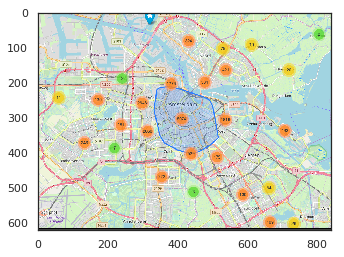

In [120]:
image = mpimg.imread("imgs/clusters.png")
plt.imshow(image)
plt.show()

In [119]:
#creating df with mean price for each neighobuurhood 
neighbourhoods = gpd.read_file(fp_neighbourhood_gjson).drop(columns = ['neighbourhood_group'])
mean_prices = listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=True)
mean_prices = pd.DataFrame([mean_prices])
mean_prices = mean_prices.T

#merging mean prices with the neighbourhood information 
neighbourhoods = pd.merge(neighbourhoods, mean_prices, right_on='neighbourhood_cleansed',left_on = 'neighbourhood', how='left')
neighbourhoods.rename(columns={'price': 'average_price'}, inplace=True)
neighbourhoods.average_price = neighbourhoods.average_price.round(decimals=0)

#creating colormap for the plot 
map_dict = neighbourhoods.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

#creating function to get the colour to fill the polygon with 
def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

#creating map and plotting results 
map2 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=neighbourhoods,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map2)
map2.save('./data/Map/Average_prices.html')

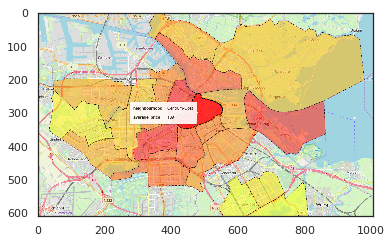

In [121]:
image = mpimg.imread("imgs/avg_prices.png")
plt.imshow(image)
plt.show()

The two maps generated above can we viewed by going to data/Map. They are titled Average_prices.html and clusters.html

We can see that the areas with the highest average price for a room are Centrum-West and Centrum-Oost. De Wallen, the right light district in Amsterdam, is on the border of these two neighoburhoods. This leads us to believe that most people are visiting Amsterdam for the nightlife and parties. Most people spend their nights in this area and prefer to stay around there after a long night of partying. 

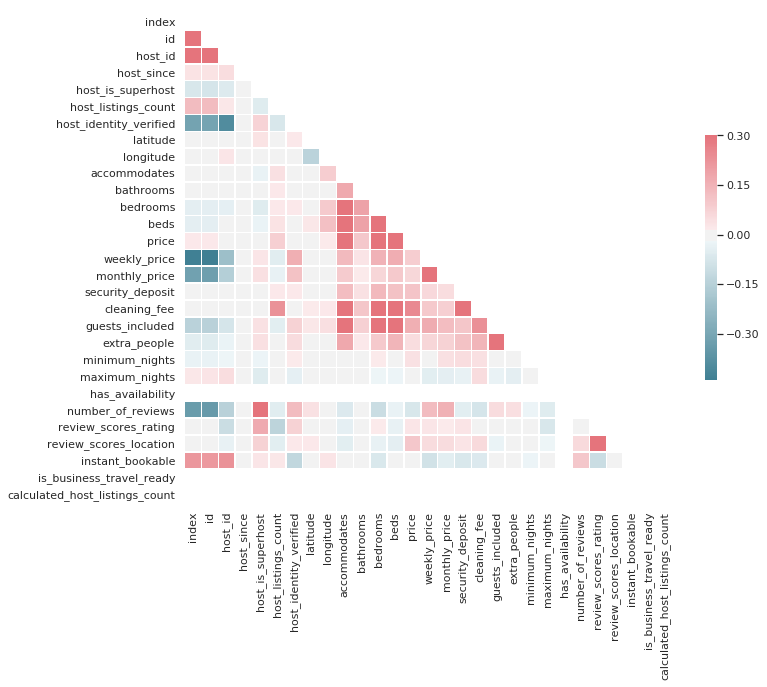

In [26]:
sns.set(style="white")

# Compute the correlation matrix
corr = listings.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

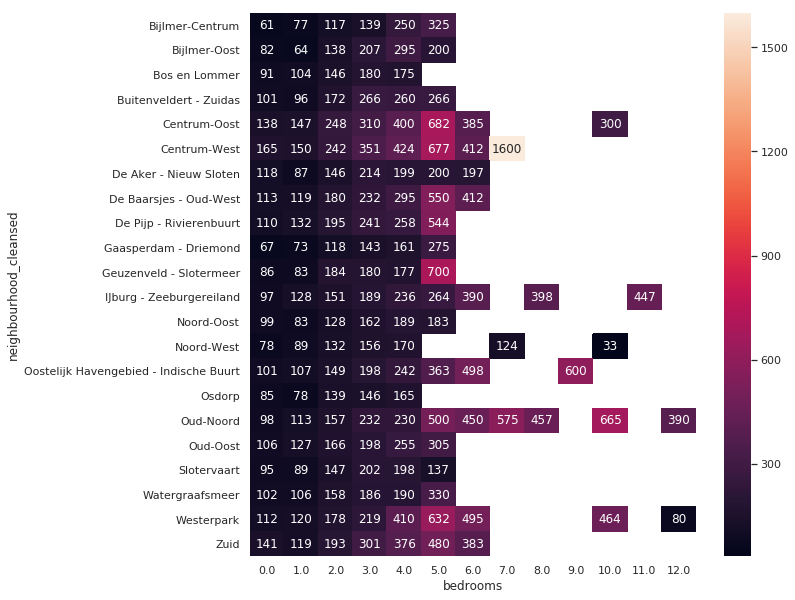

In [27]:
#creating heatmap of housing prices based on the number of bedrooms for each neighbourhood
plt.figure(figsize=(10,10))
sns.heatmap(listings.groupby([
        'neighbourhood_cleansed', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".0f")

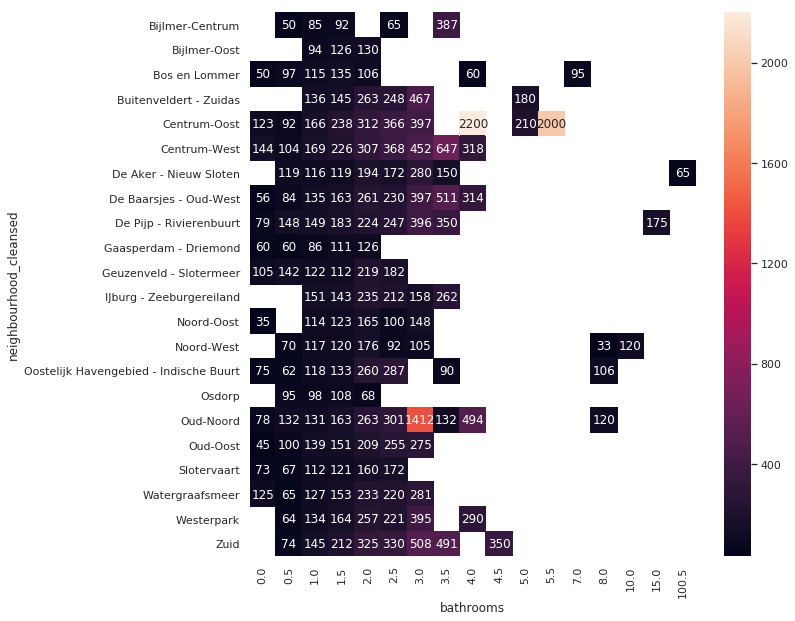

In [28]:
#creating a heatmap of the average prices based on the number of bathrooms for each neighbourhood 
plt.figure(figsize=(10,10))
sns.heatmap(listings.groupby([
        'neighbourhood_cleansed', 'bathrooms']).price.mean().unstack(),annot=True, fmt=".0f")

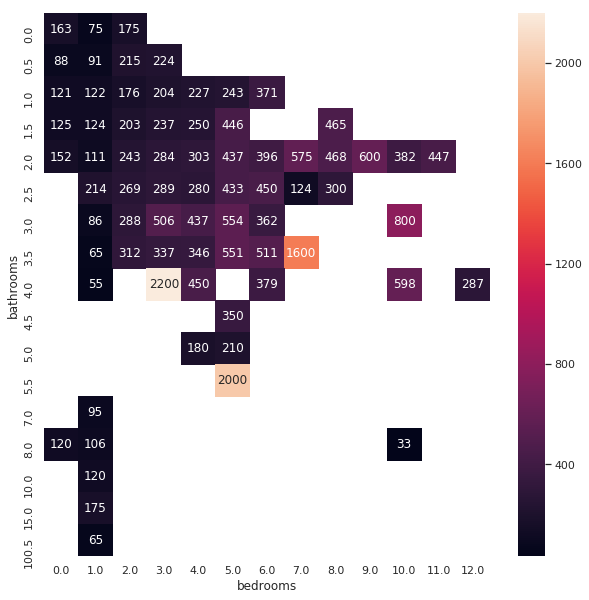

In [29]:
#getting average prices for based on the number of bathrooms and bedrooms 
plt.figure(figsize=(10,10))
sns.heatmap(listings.groupby([
        'bathrooms', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".0f")

Text(0, 0.5, 'Frequency')

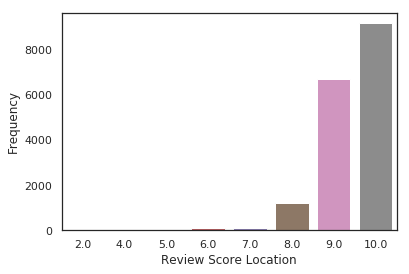

In [30]:
#plotting location review scores with data
ax = sns.barplot(listing_details_unfiltered.review_scores_location.value_counts().index, listing_details_unfiltered.review_scores_location.value_counts().values)
ax.set_xlabel('Review Score Location')
ax.set_ylabel('Frequency')

At this point we can see that 91.5% of the location review scores are a 9 or 10. This does not help anyone when they are trying to pick an Airbnb. Having a dynamic location score will definitely help eliminate this problem. 

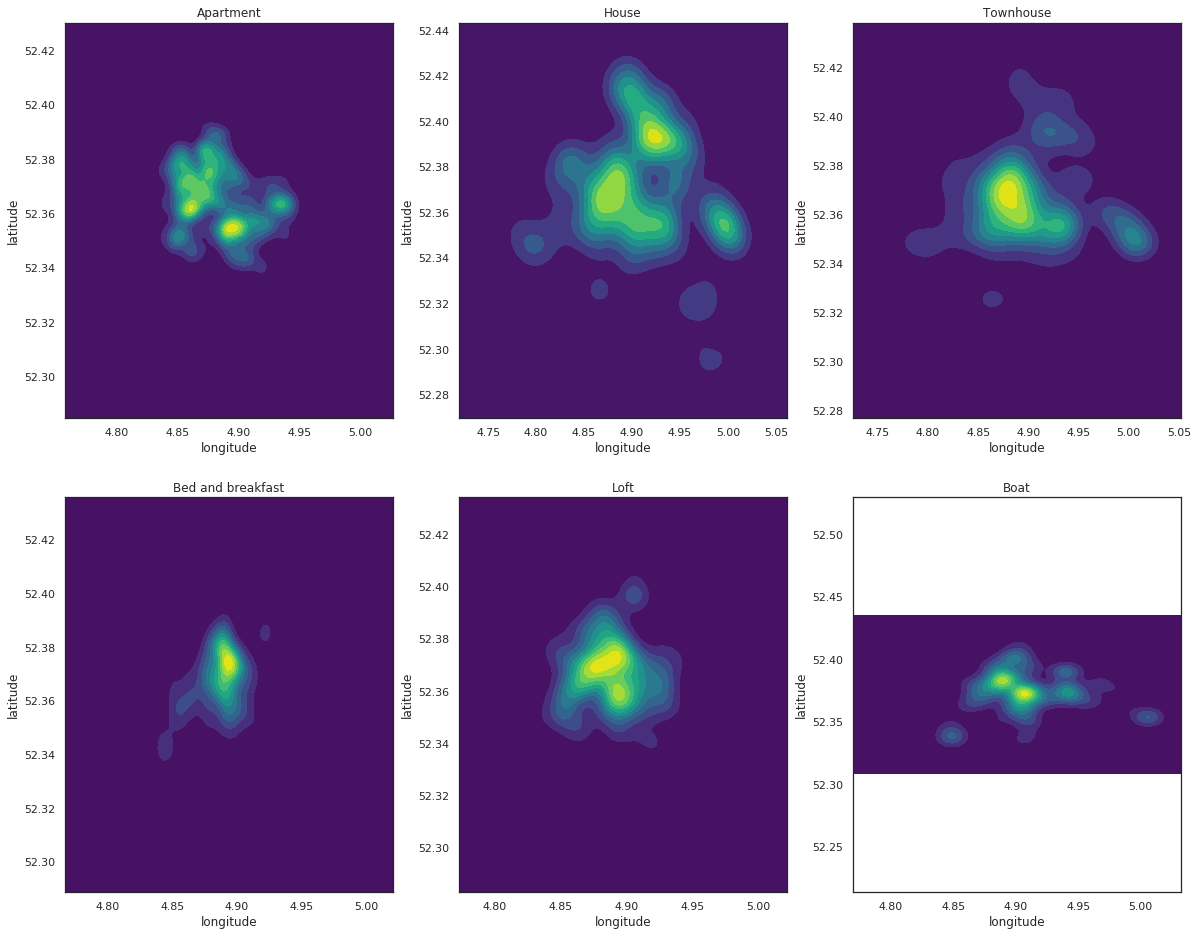

In [31]:
#plotting kde of the concentration of listings based on latitude and longitude for each property type 
rank = listings.property_type.groupby(listings.property_type).\
            count().sort_values(ascending=False)

f, axs = plt.subplots(2,3,figsize=(20,16))
axs = axs.flatten()
for i, sub in enumerate(rank.head(6).index.tolist()):
    ax = axs[i]
    subdf = listings.loc[listings['property_type']==sub,:]
    sns.kdeplot(subdf['longitude'], subdf['latitude'], shade=True,
               cmap='viridis',ax=ax)
    ax.set_title(sub)
    plt.axis('equal')

To generate some descriptive statistics about the neighbourhoods of Amsterdam dataset, we used PySAL to conduct some basic spatial analysis. We got the neighbour weights of each neighbourhood, for which we had to flatten the coordinates of each neighbourhood polygon from 3-D to 2-D. With only x and y coordinates to consider, we could assess which neighbourhoods connected to one another.

About 19% of possible neighbourhood intersections did turn out to be neighbour pairs, which we felt was fairly high. Using Queen-wise weights as our standard, the average number of neighbours for a neighbourhood was 4.18 with a standard deviation of 1.59. The total number of neighbourhoods in the dataset was 22. 

We also did K-Nearest-Neighbours analysis on the neighbourhoods data to get neighbours by this metric. First, we set the radius to Earth’s radius so as to account for the curvature of the Earth in our distance calculations. We set k=3 in this analysis as a choice based on the limited number of neighbourhoods in the dataset. This afforded us with a determination of nearby neighbourhoods to one another in Amsterdam.


In [34]:
# Flatten neighborhoods to 2D for this analysis
shp_path = "data/neighbourhoods.shp"
dataframe = gpd.read_file(shp_path)
dataframe.head()
var = loads(dataframe.loc[0].geometry.boundary.wkt)
line_2d = Polygon([xy[0:2] for xy in list(var.coords)])
coords_2d = list()
for i in range(len(dataframe.geometry)):
    var = loads(dataframe.loc[i].geometry.boundary.wkt)
    line_2d = Polygon([xy[0:2] for xy in list(var.coords)])
    coords_2d.append(line_2d)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


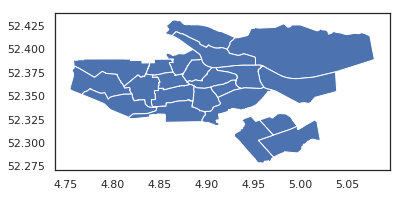

In [48]:
# Get Queen weights of each neighborhood's coordinates
dataframe['geometry'] = coords_2d
dataframe.to_file('./data/2d_hoods.shp')
shp_path2 = "./data/2d_hoods.shp"
shp = ps.lib.io.open(shp_path2)
qW = ps.lib.weights.Queen(shp)
hoods_df = gpd.read_file(shp_path2)
ax = hoods_df.plot()

In [36]:
# Shows the neighborhoods with each's list of Queen-wise neighbors
for w in qW:
    print(w)

(0, {10: 1.0, 12: 1.0})
(1, {2: 1.0, 3: 1.0, 4: 1.0, 6: 1.0})
(2, {1: 1.0, 3: 1.0})
(3, {1: 1.0, 2: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 11: 1.0})
(4, {1: 1.0, 6: 1.0, 9: 1.0})
(5, {16: 1.0, 11: 1.0, 3: 1.0, 7: 1.0})
(6, {1: 1.0, 3: 1.0, 4: 1.0, 7: 1.0, 8: 1.0, 9: 1.0})
(7, {16: 1.0, 3: 1.0, 5: 1.0, 6: 1.0, 8: 1.0, 13: 1.0, 14: 1.0})
(8, {9: 1.0, 13: 1.0, 6: 1.0, 7: 1.0})
(9, {4: 1.0, 6: 1.0, 8: 1.0, 13: 1.0, 15: 1.0})
(10, {0: 1.0, 12: 1.0})
(11, {16: 1.0, 17: 1.0, 3: 1.0, 5: 1.0})
(12, {0: 1.0, 10: 1.0})
(13, {7: 1.0, 8: 1.0, 9: 1.0, 14: 1.0, 15: 1.0})
(14, {16: 1.0, 19: 1.0, 7: 1.0, 13: 1.0, 15: 1.0})
(15, {19: 1.0, 21: 1.0, 9: 1.0, 13: 1.0, 14: 1.0})
(16, {17: 1.0, 19: 1.0, 5: 1.0, 7: 1.0, 11: 1.0, 14: 1.0})
(17, {16: 1.0, 11: 1.0, 18: 1.0, 19: 1.0})
(18, {17: 1.0, 19: 1.0, 20: 1.0})
(19, {16: 1.0, 17: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 14: 1.0, 15: 1.0})
(20, {18: 1.0, 19: 1.0, 21: 1.0})
(21, {19: 1.0, 20: 1.0, 15: 1.0})


In [37]:
# Normalize and fill rows, then calculate percent of potential intersections which are neighbors
Wmatrix, ids = qW.full()
print('Percent Non-Zero: ' + str(qW.pct_nonzero))

Percent Non-Zero: 19.00826446280992


Mean: 4.181818181818182
Standard Deviation: 1.592732412176175


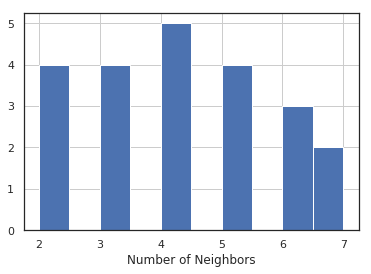

In [38]:
# Basic Description of Number of Neighbors
n_neighbors = pd.Series(list(Wmatrix.sum(axis=1)))
ax = n_neighbors.hist()
ax.set_xlabel('Number of Neighbors');
print('Mean: ' + str(n_neighbors.mean()))
print('Standard Deviation: ' + str(n_neighbors.std()))

In [39]:
# K-Nearest-Neighbors Analysis in accordance with Earth's curvature
radius = ps.lib.cg.sphere.RADIUS_EARTH_MILES
knn = ps.lib.weights.KNN.from_shapefile(shp_path2, k=3, radius=radius)

In [40]:
# First five neighborhoods and their nearest neighbors
for i in range(5):
    print((i, knn[i]))

(0, {10: 1.0, 12: 1.0, 9: 1.0})
(1, {4: 1.0, 6: 1.0, 3: 1.0})
(2, {3: 1.0, 11: 1.0, 5: 1.0})
(3, {5: 1.0, 11: 1.0, 2: 1.0})
(4, {6: 1.0, 1: 1.0, 0: 1.0})


In [41]:
# Neighborhoods closest to Bijlmer-Oost by this method
locs = [0]
for i in knn[0]:
    locs.append(i)
hoods_df.loc[locs]

,neighbourh,geometry
0,Bijlmer-Oost,"POLYGON ((4.991669 52.324436, 4.991756 52.3242..."
10,Gaasperdam - Driemond,"POLYGON ((5.021543 52.302457, 5.020643 52.3024..."
12,Bijlmer-Centrum,"POLYGON ((4.97184 52.28436, 4.971694 52.284262..."
9,Watergraafsmeer,"POLYGON ((4.969713 52.356363, 4.969595 52.3561..."


In [42]:
#completing the data cleaning by imputing the median 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(listings[['review_scores_location', 'review_scores_rating']].copy().dropna())
imputed_vals = imp_median.transform(listings[['review_scores_location', 'review_scores_rating']])
imputed_df = pd.DataFrame(imputed_vals, columns = ['review_scores_location', 'review_scores_rating'])

listings['review_scores_location'] = imputed_df['review_scores_location']
listings['review_scores_rating'] = imputed_df['review_scores_rating']

## Analysis

We created a model that recommends Airbnb listings based on a users preferences. 

In our initial plan, we wanted to convert the neighbourhood field to represent an ordinal variable. To do that we wanted to compute a score for each neighbourhood. To calculate the score we wanted to use factors like the safety, greenery, pollution and number of canals in each neighbourhood. We had attempted to do this using raster layers. However, we did run into numerous problems when working with raster calculators and decided against using this feature. 


In [51]:
#getting all data as feature layers 
attractions_fl = gis.content.get('2d917955e3024ee9bf4fb257ff94cd73')
listing_fl = gis.content.search('419b634ba980445ea29c612aef9c839c')
tram_metro = gis.content.get('ecefe11d5118489c9db2f5b8a76686c1')

 Next cell takes a while to run as it converts the entire coordinate system. Instead you could skip to the cell after

In [54]:
#converting listings df to a geopandas 
listings_gpd = gpd.GeoDataFrame.from_csv(fp_listings_details)[['latitude', 'longitude',]].reset_index()
listings_gpd['Coordinates'] = list(zip(listings_gpd.longitude, listings_gpd.latitude))
listings_gpd['Coordinates'] = listings_gpd['Coordinates'].apply(Point)
listings_gpd = gpd.GeoDataFrame(listings_gpd, geometry='Coordinates')
listings_gpd.set_geometry('Coordinates')
listings_gpd.crs = {'init' :'epsg:4326'}
listings_gpd = listings_gpd.to_crs({'init': 'epsg:2230'})
listings_gpd.to_csv('data/converted_listings.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [56]:
temp = pd.read_csv('data/converted_listings.csv')
temp['Coordinates'] = temp.Coordinates.apply(lambda x: x.split('(')[1]).apply(lambda x: x.split(')')[0].split(' ')).apply(lambda x: [float(i) for i in x]).apply(Point)
temp = temp.loc[:,'id':]
listings_gpd = gpd.GeoDataFrame(temp, geometry='Coordinates')
listings_gpd.set_geometry('Coordinates')
listings_gpd.crs = {'init' :'epsg:2230'}
listings_gpd.head()

,id,latitude,longitude,Coordinates
0,2818,52.365755,4.941419,POINT (29294004.26702854 24072333.19079106)
1,3209,52.390225,4.873924,POINT (29278916.86348251 24061397.7626379)
2,20168,52.365087,4.893541,POINT (29289721.69105516 24061792.65586083)
3,25428,52.373114,4.883668,POINT (29285930.57984116 24060879.60987052)
4,27886,52.386727,4.892078,POINT (29281877.15236629 24064813.43441492)


For our model, we first calculated the distance to the nearest metro/ tram station. To do this we working with geopandas and used the distance function. However, the distance between the listing and the nearest tram station is a euclidean distance and not the true walking distance. People who want to use the metro/ tram do not have any other means of transportation and using the true walking distance would help increase the accuracy of our results. 

In [57]:
#converting tram_metro layer to a geopandas
temp = tram_metro.layers[0].query().sdf
temp['lon'] = temp.WKT_LNG_LAT.apply(lambda x: float(x.split('(')[1].split(',')[0]))
temp['lat'] = temp.WKT_LNG_LAT.apply(lambda x: float(x.split('(')[1].split(',')[1][:-1]))
temp['Coordinates'] = list(zip(temp.lon, temp.lat))
temp['Coordinates'] = temp['Coordinates'].apply(Point)
tram_metro_gpd = gpd.GeoDataFrame(temp, geometry='Coordinates')
tram_metro_gpd.set_geometry('Coordinates')
tram_metro_gpd.crs = {'init' :'epsg:4326'}
tram_metro_gpd = tram_metro_gpd.to_crs({'init': 'epsg:2230'})

In [58]:
#getting minimum distance from each listing to the nearest metro/ tram
min_distances = []
for x in listings_gpd.index:
    min_distances.append(min(tram_metro_gpd.distance(listings_gpd.loc[x,'Coordinates']) /  5280))


In [59]:
listings_gpd['metro_dist'] = min_distances
listing_dist = listings.merge(listings_gpd, on = 'id')

In [60]:
def get_metro_dist(lat,lon):
    pt = Point(lon,lat)
    df = pd.DataFrame([pt], columns = ['Coordinates'])
    df = gpd.GeoDataFrame(df, geometry='Coordinates')
    df.set_geometry('Coordinates')
    df.crs = {'init' :'epsg:4326'}
    df = df.to_crs({'init': 'epsg:2230'})
    return (min(tram_metro_gpd.distance(df.loc[0,'Coordinates'])/5280))

We then divided our attractions into 10 sub-categories. Our aim was to get the number of attractions within a 1Km radius of the listing. We used 1Km as that is the average distance someone can walk in 10 minutes. We tried using the function find_existing_locations() to help get the desired output, but had no success with the same as we ran into issues with the spatial references and aggregating the points for each listing. We were able to get the required results using geopandas functions ‘buffer’ and ‘within’. However, this function is not the most time efficient. With the size of our dataset and the computation power on hand, it made sense to avoid this function. Instead we decided to create a bounding box around the listing, with a side of length 1Km. This may have decreased the accuracy of our results, but was the only option with our resources

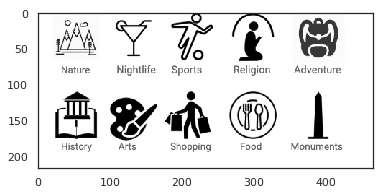

In [123]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("imgs/feats.png")
plt.imshow(image)
plt.show()

In [62]:
#creating points from the latitude and longitude coordinates 
attractions.lon = pd.to_numeric(attractions.lon, errors= 'coerce')
attractions.lat = pd.to_numeric(attractions.lat, errors= 'coerce')
attractions['Coordinates'] = list(zip((attractions.lon),(attractions.lat)))
attractions['Coordinates'] = attractions['Coordinates'].apply(Point)
attractions = attractions.drop(columns = ['SHAPE'])

In [63]:
#creating subcategory dataframes
nature_pd = attractions.loc[attractions.CAT.isin(nature)]
nightlife_pd = attractions.loc[attractions.CAT.isin(nightlife)]
sports_pd = attractions.loc[attractions.CAT.isin(sports)]
religion_pd = attractions.loc[attractions.CAT.isin(religion)]
adventure_pd = attractions.loc[attractions.CAT.isin(adventure)]
history_pd = attractions.loc[attractions.CAT.isin(history)]
arts_pd = attractions.loc[attractions.CAT.isin(arts)]
shopping_pd = attractions.loc[attractions.CAT.isin(shopping)]
food_pd = attractions.loc[attractions.CAT.isin(food)]
monuments_pd = attractions.loc[attractions.CAT.isin(monuments)]

In [64]:
#creating geopandas for each subcategory 
nature_gpd = gpd.GeoDataFrame(nature_pd, geometry='Coordinates')
nightlife_gpd = gpd.GeoDataFrame(nightlife_pd, geometry='Coordinates')
sports_gpd = gpd.GeoDataFrame(sports_pd, geometry='Coordinates')
religion_gpd = gpd.GeoDataFrame(religion_pd, geometry='Coordinates')
adventure_gpd = gpd.GeoDataFrame(adventure_pd, geometry='Coordinates')
history_gpd = gpd.GeoDataFrame(history_pd, geometry='Coordinates')
arts_gpd = gpd.GeoDataFrame(arts_pd, geometry='Coordinates')
shopping_gpd = gpd.GeoDataFrame(shopping_pd, geometry='Coordinates')
food_gpd = gpd.GeoDataFrame(food_pd, geometry='Coordinates')
monuments_gpd = gpd.GeoDataFrame(monuments_pd, geometry='Coordinates')

In [65]:
#setting geometry to the coordinate column for each subcategory geopandas df 
nature_gpd.set_geometry('Coordinates')
nightlife_gpd.set_geometry('Coordinates')
sports_gpd.set_geometry('Coordinates')
religion_gpd.set_geometry('Coordinates')
adventure_gpd.set_geometry('Coordinates')
history_gpd.set_geometry('Coordinates')
arts_gpd.set_geometry('Coordinates')
shopping_gpd.set_geometry('Coordinates')
food_gpd.set_geometry('Coordinates')
monuments_gpd.set_geometry('Coordinates')
...

Ellipsis

In [66]:
#setting the crs for each subcategory geopandas df 
nature_gpd.crs = {'init' :'epsg:4326'}
nightlife_gpd.crs = {'init' :'epsg:4326'}
sports_gpd.crs = {'init' :'epsg:4326'}
religion_gpd.crs = {'init' :'epsg:4326'}
adventure_gpd.crs = {'init' :'epsg:4326'}
history_gpd.crs = {'init' :'epsg:4326'}
arts_gpd.crs = {'init' :'epsg:4326'}
shopping_gpd.crs = {'init' :'epsg:4326'}
food_gpd.crs = {'init' :'epsg:4326'}
monuments_gpd.crs = {'init' :'epsg:4326'}

In [67]:
#converting crs and reseting index for each subcategory geopandas df 
nature_gpd = nature_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
nightlife_gpd = nightlife_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
sports_gpd = sports_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
religion_gpd = religion_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
adventure_gpd = adventure_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
history_gpd = history_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
arts_gpd = arts_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
shopping_gpd = shopping_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
food_gpd = food_gpd.to_crs({'init': 'epsg:2230'}).reset_index()
monuments_gpd = monuments_gpd.to_crs({'init': 'epsg:2230'}).reset_index()

In [68]:
#method to get number of subcategory datapoints within a bounding box of each listing 
def within_radius(df, listings):
    w_radius = []
    for x in listings.index:
        lat = (listings.loc[x,'Coordinates'].x)
        lon = (listings.loc[x,'Coordinates'].y)
        max_lat = lat+1584
        min_lat = lat-1584
        max_lon = lon+1584
        min_lon = lon-1584
        w_radius.append((df.loc[(df.x >= min_lat) & (df.x <= max_lat) & (df.y >= min_lon) & (df.y <= max_lon)]).shape[0])
    return w_radius 

Next few cells take a while to run

In [69]:
#getting number of nature attraction within a 1km distance from the listing
nature_gpd['x'] = nature_gpd['Coordinates'].x
nature_gpd['y'] = nature_gpd['Coordinates'].y
nature_radius = within_radius(nature_gpd,listing_dist)


In [70]:
#getting number of nightlife attraction within a 1km distance from the listing
nightlife_gpd['x'] = nightlife_gpd['Coordinates'].x
nightlife_gpd['y'] = nightlife_gpd['Coordinates'].y
night_radius = within_radius(nightlife_gpd,listing_dist)


In [71]:
#getting number of sports attraction within a 1km distance from the listing
sports_gpd['x'] = sports_gpd['Coordinates'].x
sports_gpd['y'] = sports_gpd['Coordinates'].y
sports_radius = within_radius(sports_gpd,listing_dist)


In [72]:
#getting number of religion attraction within a 1km distance from the listing
religion_gpd['x'] = religion_gpd['Coordinates'].x
religion_gpd['y'] = religion_gpd['Coordinates'].y
religion_radius = within_radius(religion_gpd,listing_dist)


In [73]:
#getting number of adventure attraction within a 1km distance from the listing
adventure_gpd['x'] = adventure_gpd['Coordinates'].x
adventure_gpd['y'] = adventure_gpd['Coordinates'].y
adventure_radius = within_radius(adventure_gpd,listing_dist)


In [74]:
#getting number of history attraction within a 1km distance from the listing
history_gpd['x'] = history_gpd['Coordinates'].x
history_gpd['y'] = history_gpd['Coordinates'].y
history_radius = within_radius(history_gpd,listing_dist)


In [75]:
#getting number of art attraction within a 1km distance from the listing
arts_gpd['x'] = arts_gpd['Coordinates'].x
arts_gpd['y'] = arts_gpd['Coordinates'].y
arts_radius = within_radius(arts_gpd,listing_dist)


In [76]:
#getting number of shopping attraction within a 1km distance from the listing
shopping_gpd['x'] = shopping_gpd['Coordinates'].x
shopping_gpd['y'] = shopping_gpd['Coordinates'].y
shopping_radius = within_radius(shopping_gpd,listing_dist)


In [77]:

#getting number of food attraction within a 1km distance from the listing
food_gpd['x'] = food_gpd['Coordinates'].x
food_gpd['y'] = food_gpd['Coordinates'].y
food_radius = within_radius(food_gpd,listing_dist)


In [78]:
#getting number of monument attraction within a 1km distance from the listing
monuments_gpd['x'] = monuments_gpd['Coordinates'].x
monuments_gpd['y'] = monuments_gpd['Coordinates'].y
monuments_radius = within_radius(monuments_gpd,listing_dist)


In [79]:
listing_dist['nature'] = nature_radius
listing_dist['nightlife'] = night_radius
listing_dist['sports'] = sports_radius
listing_dist['religion'] = religion_radius
listing_dist['adventure'] = adventure_radius
listing_dist['history'] = history_radius
listing_dist['arts'] = arts_radius
listing_dist['shopping'] = shopping_radius
listing_dist['food'] = food_radius
listing_dist['monuments'] = monuments_radius

In [80]:
#function to remap scores from 0 to 100 
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

We then calculated our initial GeoScore.
Weights of each feature: <br>
Nature = 10%<br>
Nightlife = 10%<br>
Sports = 10%<br>
Religion = 10%<br>
Adventure = 10%<br>
History = 10%<br>
Arts = 10%<br>
Shopping = 10%<br>
Food = 10%<br>
Monuments = 10%<br>
Metro distance = -10% (negative value because greater distances are worse)<br>
<br>
We sum each weight to calculate the final score<br>


After this we used a rescaling function to convert our score to a value between 0 and 100. This was not the best rescaling function that could be found, since the mean of our scaled score was just 40.


In [81]:
#creating a score and then remapping from 0 to 100 
listing_dist['Score'] = (listing_dist.nature*0.10) + (listing_dist.nightlife*0.10) + (listing_dist.sports*0.10) + (listing_dist.religion*0.10) + (listing_dist.adventure*0.10) + (listing_dist.history*0.10) + (listing_dist.arts*0.10) + (listing_dist.shopping*0.10) + (listing_dist.food*0.10) + (listing_dist.monuments*0.10) - (listing_dist.metro_dist * 0.10)
min_score = listing_dist.Score.min()
max_score = listing_dist.Score.max()
o_max = 100
o_min = 0
listing_dist.Score = remap(listing_dist.Score, min_score,max_score,o_min,o_max)

### Creating the model for tourists

We then created a function where you could pass in your room requirements along with your favourite attraction sub-category. We would use this to create a new attribute geoScore.

The score is computed using the following formula: <br>

Tourists favourite type of attractions = 60%
Each remaining attraction = 5%
Metro distance = -5%

We then remap that score from 0 to 100

We then queried for the room requirements and sorted our output by the attribute geoScore. 

In [82]:
#creating a new attribute score and sorting based on that score. Returns at max 20 properties 
def get_best(bed,bath, accommodates, reason_for_visit,max_price = 1000000 ,property_type = None):
    cats = ['nature','nightlife','sports','religion','adventure', 'history','arts','shopping','food','monuments']
    cats.remove(reason_for_visit)
    score = listing_dist[reason_for_visit] *0.60
    for x in cats:
        score += listing_dist[x] * 0.05
    score -= (listing_dist['metro_dist'] *0.05)
    listing_dist['attr_score'] = remap(score, score.min(),score.max(), 0,100)
    filtered = listing_dist.loc[(listing_dist.bedrooms == bed) & (listing_dist.bathrooms == bath) & (listing_dist.accommodates == accommodates) & (listing_dist.price <= max_price)]
    sorted_df = (filtered.sort_values(['attr_score','Score'], ascending = False))[:min(10, filtered.shape[0])]
    return sorted_df
    

## Summary of products and results

In [94]:
nightlife_recs = get_best(bed = 3,bath=2, accommodates = 6,max_price = 500, reason_for_visit = 'nightlife')
nightlife_recs2 = get_best(bed = 3,bath=2, accommodates = 6,max_price = 150, reason_for_visit = 'nightlife')

In [95]:
recs_sdf = pd.DataFrame.spatial.from_xy(nightlife_recs,y_column = 'latitude_y', x_column='longitude_y')
nightlife_sdf = pd.DataFrame.spatial.from_xy(nightlife_gpd,y_column = 'lat', x_column='lon')

We tested the results of our model on the following case: 
6 friends are travelling to Amsterdam to party. They are looking for a 3 bedroom, 2 bathroom Airbnb. Their initial budget is \\$500.
From our initial EDA, we know that Central-West is the neighbourhood with the best nightlife. The average 3 bedroom is Central-West is $351 and the average 2 bathroom is \\$307


In [102]:
map_night = gis.map('Amsterdam')
map_night.add_layer(neighbourhood_layer, options={'opacity':0.1})
nightlife_sdf.spatial.plot(map_widget= map_night, marker_size = 2)
recs_sdf.spatial.plot(map_widget= map_night,colors='Blues',symbol_style='d',marker_size=10)
# map_night

True

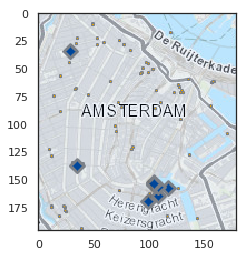

In [115]:
image = mpimg.imread("imgs/recs1.png")
plt.imshow(image)
plt.show()

Above is the map our model recommends with the given conditions. We can see that most recommendations are on the border of Central-West and Central-Oost. 
The price of our flights was higher than initially anticipated and now we only have \\$150 to spend on an Airbnb. This is much lower than the average prices in Central-West for our room requirements. We would expect the recommender system to suggest listings in other neighbourhoods. 


In [103]:
map_night2 = gis.map('Amsterdam')
map_night2.add_layer(neighbourhood_layer, options={'opacity':0.1})
nightlife_sdf.spatial.plot(map_widget= map_night2, marker_size = 2)
recs2_sdf.spatial.plot(map_widget= map_night2, colors='cool',symbol_style='d',marker_size=10)
# map_night2

True

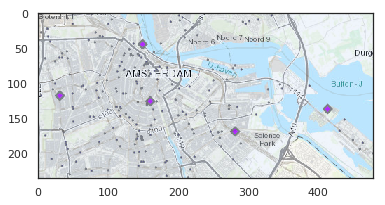

In [116]:
image = mpimg.imread("imgs/recs2.png")
plt.imshow(image)
plt.show()

We can see that is exactly what happened. Unfortunately our model only returned 5 listings. On checking the average price for a 3 bedroom, 2 bathroom, we learnt that on average it goes for \\$284. Hence, our model has generated the expected results. 


## Conclusions and future work

Completely answering our initial question would take months of research. For starters, we need a much more extensive dataset with the attractions in Amsterdam. We would also benefit if we could get star rating for each tourist attraction. That way we can give more popular attractions a higher weight in our score. Further, the restaurants listed in our attractions was very limited. We would benefit if we used a much larger dataset for this. Perhaps scrape some Yelp data for the same. Further, we could weigh restaurants that serve good local food higher, promoting people to expand their culinary palette.

Secondly, when calculating our geoScore, we subset those attractions that are approximately within 1Km from the listing. Our distance function calculates the euclidean distance, rather than the actual walking distance which reduces the accuracy of our results. Further, bicycles are one of the most common modes of transportation in Amsterdam and we did not consider the same for our model. We could perhaps calculate another buffer for attractions that are within a 10 minute bicycle ride from the listing. Other things that we must consider for our geoScore are the distance to train stations, city center, airports, ATM’s, supermarkets. It would interesting considering how the safety, pollution levels and beauty of a neighbourhood would affect our model. Sometimes people would rather commute a longer distance in order to stay in a nice, safe neighbourhood. Factors that could affect the beauty of a neighbourhood could include if the listing overlooks canals, and the amount of greenery. 

It would be interesting to run a similar model on other cities in the world and see how Amsterdam is similar and different to these other cities. Further, by using this data, Airbnb will understand customer preferences. For example, they might learn that I choose listings with a highly weighted sports geoScore and in turn they could recommend cities with a strong sport culture that I could visit in the future. 


In [ ]:
raise NotImpxlementedError()